Steps in preprocessing pipleline:


- transpose non tranposed songs so we have complete dataset of 4/4 C major songs
- generate vocab
- break into 8 measure chunks with two measure overlap
-divide into notes vs chords (inputs vs outputs)
-one hot as 16th note frames, batch, pad etc

In [ ]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import pandas as pd
import re

import random

import numpy as np

import json

import matplotlib.pyplot as plt

import os
import music21

import math

from google.colab import drive
drive.mount('/content/drive')

torch.manual_seed(1)

Mounted at /content/drive


In [ ]:

is_cuda = torch.cuda.is_available()

# use GPU is have it
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [ ]:

# enables music21 to render images of musical notes : https://colab.research.google.com/drive/17Fql7pyK3xsO8KmZorvb1tBoPomidCPB#scrollTo=9JBRee7BtvVL
print('installing lilypond...')
!apt-get install lilypond > /dev/null

print('installing musescore...')
!sudo apt-get install musescore > /dev/null
# converts midi files to wav files into order to play them
print('installing fluidsynth...')
!apt-get install fluidsynth > /dev/null
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2


installing lilypond...
Extracting templates from packages: 100%
installing musescore...
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 54.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
installing fluidsynth...


In [ ]:
from IPython.display import Image, Audio

def show(music):
  display(Image(str(music.write('lily.png'))))

def play(music):
  filename = music.write('mid')
  !fluidsynth -ni font.sf2 $filename -F $filename\.wav -r 16000 > /dev/null
  display(Audio(str(filename) + '.wav'))


In [ ]:
from ctypes import c_bool
from music21 import *


path1 = "/content/drive/MyDrive/Colab Notebooks/Yale Senior Thesis /WIKIFONIA_DATASET.json"

path2 = "/content/drive/MyDrive/Colab Notebooks/Yale Senior Thesis /JAZZ_LS_DATASET.json"

path3 = "/content/drive/MyDrive/Colab Notebooks/Yale Senior Thesis /PDSA_DATASET.json"

path4 = "/content/drive/MyDrive/Colab Notebooks/Yale Senior Thesis /CHORD_MELODY_DATASET.json"


with open(path1, 'r') as json_file:
    combined_wikifonia_data = json.load(json_file)


with open(path2, 'r') as json_file:
    combined_jazz_data = json.load(json_file)


with open(path3, 'r') as json_file:
    combined_pdsa_data = json.load(json_file)

with open(path4, 'r') as json_file:
    combined_chord_melody_data = json.load(json_file)



In [ ]:
# generate vocabulary
REST_TOKEN = "rest"
SOS_TOKEN = "<SOS>"
EOS_TOKEN = "<EOS>"

in2note = {}
note2in = {}

in2chord = {}
chord2in = {}

for i in range(12):
  in2note[i] = i
  note2in[i] = i

note2in["<EOS>"] = len(note2in)
in2note[len(in2note)] = "<EOS>"

note2in["rest"] = len(note2in)
in2note[len(in2note)] = "rest"


for input,output in combined_wikifonia_data:
  for chord in output:
    if chord not in chord2in:
      chord2in[chord] = len(chord2in)
      in2chord[len(in2chord)] = chord

print("vocab size after wikifonia is: ", len(chord2in))

for input,output in combined_jazz_data:
  for chord in output:
    if chord not in chord2in:
      chord2in[chord] = len(chord2in)
      in2chord[len(in2chord)] = chord

print("vocab size after wikifonia+jazz is: ", len(chord2in))

for input,output in combined_pdsa_data:
  for chord in output:
    if chord not in chord2in:
      chord2in[chord] = len(chord2in)
      in2chord[len(in2chord)] = chord

print("vocab size after wikifonia+jazz+pdsa is: ", len(chord2in))

for input,output in combined_chord_melody_data:
  for chord in output:
    if chord not in chord2in:
      chord2in[chord] = len(chord2in)
      in2chord[len(in2chord)] = chord

print("vocab size after wikifonia+jazz+pdsa+chord_melody is: ", len(chord2in))

vocab size after wikifonia is:  1176
vocab size after wikifonia+jazz is:  1191
vocab size after wikifonia+jazz+pdsa is:  1191
vocab size after wikifonia+jazz+pdsa+chord_melody is:  1196


In [ ]:
print(chord2in)

print(len(chord2in))

print(note2in)
print(in2note)

{'<SOS>': 0, 'C': 1, 'D#o7': 2, 'G': 3, 'Em7': 4, 'Dm9': 5, 'G13': 6, 'G7': 7, 'C/E': 8, 'Co7': 9, 'Dm7': 10, 'Gm6': 11, 'A7': 12, 'Fm': 13, '<EOS>': 14, 'Am': 15, 'Cm': 16, 'D13': 17, 'B-m6': 18, 'Dm': 19, 'G+': 20, 'D7': 21, 'Do7': 22, 'Am7': 23, 'Go7': 24, 'F6': 25, 'E7': 26, 'A': 27, 'Fo7': 28, 'B7': 29, 'Bm7': 30, 'Amaj7': 31, 'D': 32, 'E-dim': 33, 'F': 34, 'F/G': 35, 'Gm6/E': 36, 'A7/C#': 37, 'B7/D#': 38, 'Em': 39, 'F/D': 40, 'C7/B-': 41, 'A-7': 42, 'Cpedal': 43, 'Bbpedal': 44, 'E': 45, 'Fpedal': 46, 'E7 add b9': 47, 'Am6': 48, 'B/o7': 49, 'Am7/G': 50, 'F#/o7': 51, 'E7 alter #5 add #9 add #11': 52, 'A9': 53, 'G9': 54, 'Gm7': 55, 'C7': 56, 'Fmaj7': 57, 'B-maj7': 58, 'B-9': 59, 'B-': 60, 'B-7': 61, 'Gm': 62, 'B9': 63, 'C9': 64, 'A-9': 65, 'Fmaj7/G': 66, 'A-': 67, 'E-m7': 68, 'D-maj7': 69, 'Cdim': 70, 'Dm7/G': 71, 'B7 add #9': 72, 'C6': 73, 'G7 add b9': 74, 'Fm6': 75, 'D7/F#': 76, 'E-': 77, 'G#dim': 78, 'C+': 79, 'Fm7': 80, 'E-7': 81, 'Dpedal': 82, 'Gpedal': 83, 'Dm6': 84, 'A/G': 85

In [ ]:
# print(combined_wikifonia_data[:3])

for i,o in combined_wikifonia_data[:3]:
  print(len(i))
  print(len(o))
  print("----")
for i,o in combined_jazz_data[:3]:
  print(len(i))
  print(len(o))
  print("----")
for i,o in combined_pdsa_data[:3]:
  print(len(i))
  print(len(o))
  print("----")
for i,o in combined_chord_melody_data[:3]:
  print(len(i))
  print(len(o))

129
18
----
129
18
----
129
18
----
129
18
----
129
18
----
129
18
----
129
18
----
129
18
----
129
18
----
129
18
129
18
129
18


In [ ]:
# combine datasets

combined_data = combined_jazz_data+combined_wikifonia_data+combined_pdsa_data+combined_chord_melody_data

In [ ]:
for input,output in combined_chord_melody_data[:2]:
  print(input)

[4, 4, 3, 3, 4, 4, 3, 3, 4, 4, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 'rest', 'rest', 'rest', 'rest', 'rest', 'rest', 0, 0, 2, 2, 2, 2, 0, 0, 0, 0, 9, 9, 9, 9, 0, 0, 9, 9, 0, 0, 0, 0, 0, 0, 9, 9, 9, 9, 9, 9, 'rest', 'rest', 9, 9, 4, 4, 2, 2, 0, 0, 0, 0, 0, 0, 7, 7, 7, 7, 7, 7, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 4, 4, 3, 3, 4, 4, 3, 3, 4, 4, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 'rest', 'rest', 'rest', 'rest', 4, 4, 3, 3, '<EOS>']
[4, 4, 3, 3, 4, 4, 3, 3, 4, 4, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 'rest', 'rest', 'rest', 'rest', 4, 4, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 'rest', 'rest', 7, 7, 7, 7, 8, 8, 9, 9, 9, 9, 9, 9, 9, 9, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 11, 11, 1, 1, 1, 1, 9, 9, 9, 9, 5, 5, 6, 6, 6, 6, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 5, 5, 6, 6, 9, 9, 6, 6, 4, 4, 4, 4, 2, 2, 2, 2, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, '<EOS>']


In [ ]:
# encode
for input,output in combined_data:
  for i,note in enumerate(input):
    input[i] = note2in[note]
  for i,chord in enumerate(output):
    output[i] = chord2in[chord]

In [ ]:
from torch.utils.data import DataLoader
BATCH_SIZE = 128
def custom_collate_fn(batch):
    input_data, output_data = zip(*batch)

    input_data = torch.tensor(input_data)
    output_data = torch.tensor(output_data)

    return input_data, output_data

# Split into training/test set and feed into dataloader
TRAINING_SPLIT = 0.8

split_indice = int(len(combined_data)*TRAINING_SPLIT)

training_data = combined_data[:split_indice]
test_data = combined_data[split_indice:]

training_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE,collate_fn=custom_collate_fn)
test_dataloader =  DataLoader(test_data, batch_size=BATCH_SIZE,collate_fn=custom_collate_fn)




In [ ]:
x,y = next(iter(training_dataloader))

print(x.shape)

print(y.shape)
print(len(x),len(y))

print(x,y)

torch.Size([128, 129])
torch.Size([128, 18])
128 128
tensor([[ 9,  9,  9,  ...,  2,  6, 12],
        [ 4,  4,  4,  ...,  6,  4, 12],
        [ 7,  7,  7,  ..., 13, 13, 12],
        ...,
        [ 7,  7,  7,  ...,  2,  2, 12],
        [ 0,  0,  0,  ...,  4,  4, 12],
        [ 7,  7,  7,  ...,  0,  0, 12]]) tensor([[  0,  32,  29,  ...,  32,  32,  14],
        [  0, 420, 420,  ...,   3,  39,  14],
        [  0,   1,   1,  ...,   1,   1,  14],
        ...,
        [  0,   1,   1,  ...,  21,   7,  14],
        [  0,   1,   1,  ...,   1,  12,  14],
        [  0,   7,   7,  ...,   1,   1,  14]])


Now that data is processed, we create model

In [ ]:
# pure transformer model
class PositionalEncoding(nn.Module):
  def __init__(self,dim_model,dropout_p,max_len):
    super().__init__()

    self.dropout = nn.Dropout(dropout_p)

    pos_encoding = torch.zeros(max_len,dim_model)
    positions_list = torch.arange(0, max_len, dtype=torch.float).view(-1, 1) # 0, 1, 2, 3, 4, 5
    division_term = torch.exp(torch.arange(0, dim_model, 2).float() * (-math.log(10000.0)) / dim_model) # 1000^(2i/dim_model)

    # PE(pos, 2i) = sin(pos/1000^(2i/dim_model))
    pos_encoding[:, 0::2] = torch.sin(positions_list * division_term)

    # PE(pos, 2i + 1) = cos(pos/1000^(2i/dim_model))
    pos_encoding[:, 1::2] = torch.cos(positions_list * division_term)

    pos_encoding = pos_encoding.unsqueeze(0).transpose(0, 1)
    self.register_buffer("pos_encoding",pos_encoding)

  def forward(self, token_embedding: torch.tensor) -> torch.tensor:
      # Residual connection + pos encoding
      return self.dropout(token_embedding + self.pos_encoding[:token_embedding.size(0), :])


class Transformer(nn.Module):

  def __init__(
      self,
      inputVocab,
      outputVocab,
      input_embedding_dim,
      output_embedding_dim,
      num_heads,
      num_encoder_layers,
      num_decoder_layers,
      dropout_p,
      dim_feedforward
  ):

    super().__init__()
    self.model_type = "Transformer"
    self.input_embedding_dim = input_embedding_dim
    self.output_embedding_dim = output_embedding_dim

    self.input_positional_encoder = PositionalEncoding(dim_model=input_embedding_dim,dropout_p=dropout_p,max_len=5000)
    self.output_positional_encoder = PositionalEncoding(dim_model=output_embedding_dim,dropout_p=dropout_p,max_len=5000)



    self.inputEmbedding = nn.Embedding(inputVocab,input_embedding_dim)
    self.targetEmbedding = nn.Embedding(outputVocab,output_embedding_dim)

    self.transformer = nn.Transformer(
            d_model=input_embedding_dim,
            nhead=num_heads,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dropout=dropout_p, batch_first=True,
            dim_feedforward = dim_feedforward
        )

    self.out = nn.Linear(output_embedding_dim,outputVocab)

  def forward(self,src,tgt,tgt_mask=None):
       # Src size must be (batch_size, src sequence length)
        # Tgt size must be (batch_size, tgt sequence length)
        src = self.inputEmbedding(src) * math.sqrt(self.input_embedding_dim)
        tgt = self.targetEmbedding(tgt) * math.sqrt(self.output_embedding_dim)

        src = self.input_positional_encoder(src)
        tgt = self.output_positional_encoder(tgt)

        transformer_out = self.transformer(src, tgt, tgt_mask=tgt_mask)
        out = self.out(transformer_out)


        return out


  def get_tgt_mask(self,size):
    mask = torch.tril(torch.ones(size,size) == 1)
    mask = mask.float()

    mask = mask.masked_fill(mask == 0, float('-inf'))
    mask = mask.masked_fill(mask == 1, float(0.0))

    return mask



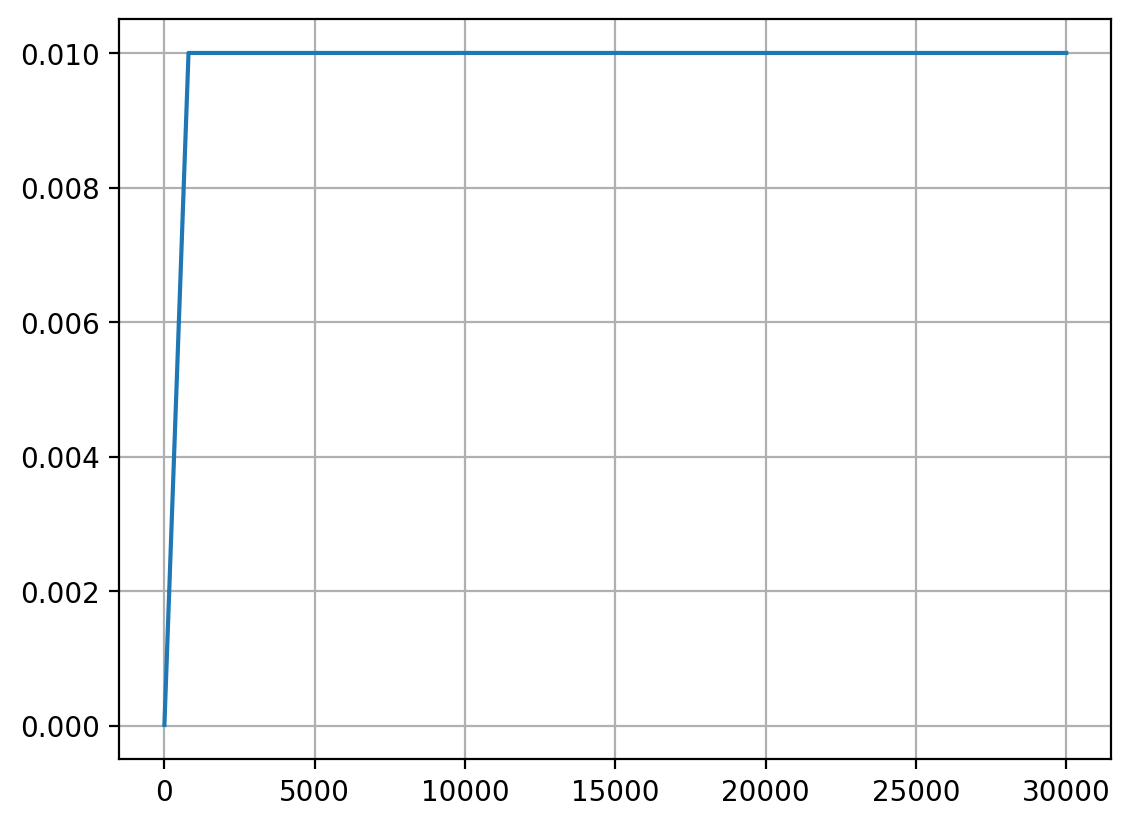

In [ ]:
# implement learning rate warmup
# inspired from: https://stackoverflow.com/questions/67136333/learning-rate-scheduler-in-pytorch


def warmup(base_lr, current_step, warmup_steps, boundaries, values):

    #warmup phase
    if current_step < warmup_steps:
        return float(current_step / warmup_steps * base_lr)
    # check boundaries
    else:
        # first index in 'boundaries' greater than current_step
        s = next((x[0] for x in enumerate(boundaries) if x[1] > current_step), -1)
        return values[s-1]

# def warmup(current_step, warmup_steps,training_steps):
#   if current_step < warmup_steps:  # current_step / warmup_steps * base_lr
#       return float(current_step / warmup_steps)
#   else:                                 # (num_training_steps - current_step) / (num_training_steps - warmup_steps) * base_lr
#       return max(0.0, float(training_steps - current_step) / float(max(1, training_steps - warmup_steps)))


# lr_scheduler.step() for using it in your training loop

max_steps = 30000
base_lr = 0.01
boundaries = [1000, 9000]
values = [base_lr, base_lr]
warmup_steps = 800

x = []
y = []
for current_step in range(1, max_steps):
    x.append(current_step)
    y.append(warmup(base_lr, current_step, warmup_steps, boundaries, values))


fig, ax = plt.subplots()
ax.plot(x, y)
ax.grid()
fig.savefig("test.png")


In [ ]:
len(training_dataloader)

192

In [ ]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

hidden_size = 256
num_layers = 4
lr = 0.01
dim_feedforward = 50
num_heads = 4
dropout_p = 0.1
input_embedding_dim = 128
output_embedding_dim = 128

model = Transformer(
      inputVocab=len(note2in),outputVocab=len(chord2in), input_embedding_dim=input_embedding_dim,output_embedding_dim=output_embedding_dim
      ,num_heads=2, num_encoder_layers=num_layers, num_decoder_layers=num_layers, dropout_p=dropout_p,
      dim_feedforward=dim_feedforward)


model.to(device)
torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

losses = []
validation_losses = []

optimizer = torch.optim.Adam(model.parameters(),amsgrad=True,lr=lr)

lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda step: warmup(lr, step, warmup_steps, boundaries,values))


loss_fn = nn.CrossEntropyLoss()


def run_epoch():

    for inputs,targets in training_dataloader:

      inputs = inputs.to(device)
      targets = targets.to(device)

      # forward pass
      # create mask for target sequence

      target_input = targets[:,:-1]

      target_expected = targets[:,1:]

      tgt_mask = model.get_tgt_mask(target_input.size(1)).to(device)

      output = model(inputs,target_input, tgt_mask)
      output = output.permute(0,2,1)

      loss = loss_fn(output, target_expected)

      # compute gradients
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      lr_scheduler.step()

    print("Loss:",loss.item())
    losses.append(loss.item())

def run_test_epoch():

    for inputs,targets in test_dataloader:

      inputs = inputs.to(device)
      targets = targets.to(device)

      # forward pass
      # create mask for target sequence

      target_input = targets[:,:-1]
      target_expected = targets[:,1:]

      tgt_mask = model.get_tgt_mask(target_input.size(1)).to(device)

      output = model(inputs,target_input, tgt_mask)
      output = output.permute(0,2,1)

      loss = loss_fn(output, target_expected)


    print("Validation Loss:",loss.item())
    validation_losses.append(loss.item())



In [ ]:
for i in range(90):
  print("Epoch",str(i)+":")
  run_epoch()
  if i % 5 == 0:
    run_test_epoch()
  print(get_lr(optimizer))

plt.plot(losses)
plt.plot(validation_losses)

Epoch 0:
Loss: 5.360713958740234
Validation Loss: 6.025630474090576
2.3999999999999997e-05
Epoch 1:
Loss: 4.121720314025879
4.7999999999999994e-05
Epoch 2:
Loss: 3.1707465648651123
7.2e-05
Epoch 3:
Loss: 2.721548318862915
9.599999999999999e-05
Epoch 4:
Loss: 2.4973695278167725
0.0001
Epoch 5:
Loss: 2.361941337585449
Validation Loss: 3.414827346801758
0.0001
Epoch 6:
Loss: 2.2454519271850586
0.0001
Epoch 7:
Loss: 2.1778156757354736
0.0001
Epoch 8:
Loss: 2.1302032470703125
0.0001
Epoch 9:
Loss: 2.098397731781006
0.0001
Epoch 10:
Loss: 2.062178134918213
Validation Loss: 3.1255855560302734
0.0001
Epoch 11:
Loss: 2.0475211143493652
0.0001
Epoch 12:
Loss: 2.0004777908325195
0.0001
Epoch 13:
Loss: 1.977371096611023
0.0001
Epoch 14:
Loss: 1.9669264554977417
0.0001
Epoch 15:
Loss: 1.962372064590454
Validation Loss: 2.9569692611694336
0.0001
Epoch 16:
Loss: 1.9409534931182861
0.0001
Epoch 17:
Loss: 1.9329909086227417
0.0001
Epoch 18:
Loss: 1.910431981086731
0.0001
Epoch 19:
Loss: 1.8933217525482

KeyboardInterrupt: ignored

In [ ]:
# turn output back into music that can be heard
def viewPhrase(input,output,playScore=False):

  phrase = stream.Part(id="melody")
  chordPhrase = stream.Part(id="chords")

  score = stream.Score(id='mainScore')
  print(input)
  for noteDur in input:
    if noteDur[0] == "rest": # indicates rest:
      nextNote = note.Rest()
    else:
      nextNote = note.Note(noteDur[0]+24)
    nextNote.duration.quarterLength = noteDur[1]/4.0 # divide note duration by 4 to get format useful to music21
    nextNote.octave = 5
    phrase.append(nextNote)

  currOffset = 0
  for chordDur in output:
    # filter out word alter to fit with music21 expected input format
    chordDur[0] = re.sub(r'\balter\b', '', chordDur[0])
    chordDur[0] = re.sub(r'\badd\b', '', chordDur[0])

    sym = harmony.ChordSymbol(chordDur[0])
    sym.quarterLength = chordDur[1]*2
    sym = sym.transpose('P8')
    sym.writeAsChord = True
    chordPhrase.insert(currOffset,sym)

    # chord_sym = harmony.ChordSymbol(chordDur[0])
    # chord_sym.writeAsChord = False
    # phrase.insert(currOffset,chord_sym)

    currOffset += chordDur[1]*2

  score.insert(0, phrase)
  score.insert(0, chordPhrase)

  score.insert(0, metadata.Metadata())
  score.append(music21.tempo.MetronomeMark(number=120))

  show(score)
  if(playScore):
    play(score)


In [ ]:
del note
from music21 import *

Training set example:
Actual chords:  ['<SOS>', 'C', 'A7', 'D7', 'G7', 'D7', 'G7', 'C', 'C', 'C', 'G#7', 'Dm7', 'G7', 'C/E', 'G#7/E-', 'Dm7', 'G7', '<EOS>']
[[7, 3], [6, 1], [5, 3], [4, 1], [9, 8], ['rest', 3], [9, 1], [0, 3], [9, 1], [4, 8], ['rest', 3], [9, 1], [0, 3], [9, 1], [4, 6], [0, 14], ['rest', 4], [7, 8], [8, 8], [9, 4], [5, 4], [4, 2], [2, 6], [7, 8], [8, 8], [9, 4], [5, 4], [4, 2], [2, 6]]
7
6
5
4
9
9
0
9
4
9
0
9
4
0
7
8
9
5
4
2
7
8
9
5
4
2


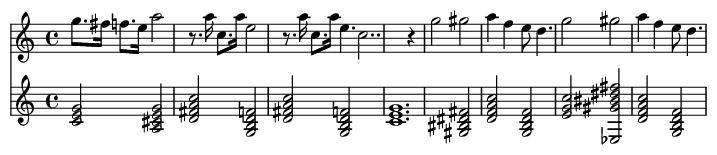

['C', 'C', 'A7', 'D7', 'C', 'D7', 'C', 'C', 'C', 'C', 'C', 'G7', 'C', '<EOS>', 'Dm7', 'G7', '<EOS>']
Decoded predicted chords:  ['C', 'C', 'A7', 'D7', 'C', 'D7', 'C', 'C', 'C', 'C', 'C', 'G7', 'C', '<EOS>', 'Dm7', 'G7', '<EOS>']
[[7, 3], [6, 1], [5, 3], [4, 1], [9, 8], ['rest', 3], [9, 1], [0, 3], [9, 1], [4, 8], ['rest', 3], [9, 1], [0, 3], [9, 1], [4, 6], [0, 14], ['rest', 4], [7, 8], [8, 8], [9, 4], [5, 4], [4, 2], [2, 6], [7, 8], [8, 8], [9, 4], [5, 4], [4, 2], [2, 6]]
7
6
5
4
9
9
0
9
4
9
0
9
4
0
7
8
9
5
4
2
7
8
9
5
4
2


ValueError: ignored

In [ ]:
# test on random examples from validation set

def decode_stream(melody):
  decoded_melody = []
  count = 0
  for i,note in enumerate(melody):
    if i >= 1 and note != melody[i-1]:
      decoded_melody.append([melody[i-1],count])
      count = 1
    else:
      count += 1

  decoded_melody.append([melody[-1],count])

  return decoded_melody

def training_example():
  rand_inputs,rand_targets = random.choice(training_data)

  rand_inputs = torch.tensor(rand_inputs).unsqueeze(0)
  rand_targets = torch.tensor(rand_targets).unsqueeze(0)

  inputs = rand_inputs.to(device)
  targets = rand_targets.to(device)

  target_input = targets[:,:-1]
  target_expected = targets[:,1:]

  tgt_mask = model.get_tgt_mask(target_input.size(1)).to(device)

  output = model(inputs,target_input, tgt_mask)
  predicted_chords = torch.argmax(output,dim=2)
  output = output.permute(0,2,1)

  loss = loss_fn(output, target_expected)

  actual_chords = [in2chord[chord] for chord in rand_targets.squeeze().tolist()]
  predicted_chords = [in2chord[chord] for chord in predicted_chords.squeeze().tolist()]

  print("Actual chords: ", actual_chords)

  decoded_melody = [in2note[note] for note in rand_inputs.squeeze().tolist()]
  decoded_melody = decode_stream(decoded_melody[:-1])
  decoded_chords = decode_stream(actual_chords[1:-1])
  decoded_predicted_chords = decode_stream(predicted_chords[:-1])

  viewPhrase(decoded_melody,decoded_chords)

  print(predicted_chords)
  print("Decoded predicted chords: ", predicted_chords)
  viewPhrase(decoded_melody,decoded_predicted_chords,playScore=True)
  print("Loss: ", loss.item())
def test_example():
  rand_inputs,rand_targets = random.choice(test_data)

  rand_inputs = torch.tensor(rand_inputs).unsqueeze(0)
  rand_targets = torch.tensor(rand_targets).unsqueeze(0)

  inputs = rand_inputs.to(device)
  targets = rand_targets.to(device)



  target_input = targets[:,:-1]
  target_expected = targets[:,1:]

  tgt_mask = model.get_tgt_mask(target_input.size(1)).to(device)

  output = model(inputs,target_input, tgt_mask)
  predicted_chords = torch.argmax(output,dim=2)
  output = output.permute(0,2,1)

  loss = loss_fn(output, target_expected)


  actual_chords = [in2chord[chord] for chord in rand_targets.squeeze().tolist()]
  print("Decoded predicted chords: ", [in2chord[chord] for chord in predicted_chords.squeeze().tolist()])
  print("Actual chords: ", actual_chords)
  print("Loss: ", loss.item())

  decoded_melody = [in2note[note] for note in rand_inputs.squeeze().tolist()]
  decoded_melody = decode_stream(decoded_melody[:-1])
  decoded_chords = decode_stream(actual_chords[1:-1])


  viewPhrase(decoded_melody,decoded_chords)

print("Training set example:")
training_example()
print("-------")
print("Test set example: ")
test_example()


In [ ]:
def top_k_sampling(logits,k):

  zeros = torch.full(logits.shape, float('-inf'), device=device)

  values, indices = torch.topk(logits, k, dim=-1) # gets indices of top k most probable tokens

  zeros.scatter_(-1, indices, values) # scatter indices of most probable tokens onto zeroed out logits

  # return top k tokens for sampling
  return zeros

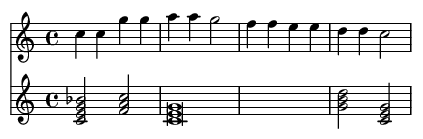

['<SOS>', 'C7', 'F', 'C', 'C', 'C', 'C', 'G', 'C']


In [ ]:
# inference

k = 10

def encode_melody(melody):
  encoded = []
  for noteDur in melody:
      noteName = (noteDur[0]%12)
      encoded_note = note2in[noteName]
      encoded_note = [encoded_note]*noteDur[1] # repeat the note its duration number of times (in 16th notes)
      encoded += encoded_note

  encoded.append(note2in[EOS_TOKEN])
  return encoded
def harmonize_melody(melody,temp=1):
  encoded = encode_melody(melody)
  inputs = torch.tensor(encoded).to(device)
  inputs = inputs.unsqueeze(0)

  MAX_LENGTH = math.ceil((inputs.size(1)-1)/8) # TODO: as inputs are in 16th notes, divide by 8 to get maximum number of HALF NOTES
  sequence = torch.tensor([chord2in[SOS_TOKEN]],device=device)
  sequence = sequence.unsqueeze(0)

  while sequence.size(dim=1) <= MAX_LENGTH:

    tgt_mask = model.get_tgt_mask(sequence.size(1)).to(device)

    output = model(inputs,sequence,tgt_mask)


    # scale logits by temperature, sample according to selected method (top k, nucleus etc), softmax, sample chord from resulting probabilities
    output = output/temp

    probabilities = top_k_sampling(output[:,-1],k)


    probabilities = F.softmax(probabilities, dim=-1)

    #print("printing", probabilities)

    sampled_chord = torch.multinomial(probabilities, 1)


    next_item = sampled_chord #torch.argmax(output,dim=-1)[:,-1]
   # print(output,output.shape)
    next_item = torch.tensor([[next_item.item()]], device=device)

    # Concatenate previous input with next chord
    sequence = torch.cat((sequence, next_item), dim=1)

    # Stop if model predicts end of sentence
    if next_item.view(-1).item() == chord2in[EOS_TOKEN]:
        break

  return [in2chord[chord] for chord in sequence.squeeze().tolist()]


# harmonize melody in form of [midi note, duration in 16th notes]
melody = [[60,4], [62,4],[64,4],[62,4],[64,4],[65,2],[67,2],[69,4],[67,4],[62,4],
 [64,4],[65,4],[65,4],[67,4],[69,2],[71,2],[72,4],[72,4],[60,4],
 [64,4],[65,4],[65,4],[67,4],[69,2],[71,2],[72,4],[72,4]]

twinkle_melody =  [[60,4],[60,4], [67,4],[67,4],[69,4],[69,4], [67,8],[65,4],[65,4],[64,4],[64,4],[62,4],[62,4],[60,8]]
sequence = harmonize_melody(twinkle_melody,temp=1.0)

viewPhrase(twinkle_melody,decode_stream(sequence[1:]),playScore=True)
print(sequence)

In [ ]:
# save model
model_kwargs =  {'inputVocab':len(in2note),'outputVocab':len(chord2in), 'input_embedding_dim': input_embedding_dim, 'output_embedding_dim': output_embedding_dim,'num_heads':num_heads, 'num_encoder_layers': num_layers,'num_decoder_layers':num_layers,'dropout_p':dropout_p,'dim_feedforward':dim_feedforward}
model_type = "Transformer"
trained_model = {'model':[model_kwargs,model.state_dict(),model_type]}


torch.save(trained_model,'/content/drive/MyDrive/Colab Notebooks/Yale Senior Thesis /pretrained_model.pth')